In [51]:
from torch import nn, optim
import os
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy.random import default_rng
import torch
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import libpysal
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.cluster import KMeans
from collections import Counter

In [60]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    
    for filename in os.listdir(path):
        print(filename)
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [61]:
def create_CNN_samples(grid, block, dims = 39):
    
    nonzero = np.transpose(grid[:,:,-2].nonzero()) # Get indices of nonzero componetns
    size = nonzero.shape[0]
    width = block * 2 + 1 # calculate widht and height. Needed later on
    
    X = np.zeros((size, width, width, dims))
    Y = np.zeros(size)
    ID = np.zeros(size)
    Y_1 = np.zeros(size)
    
    for idx, i in enumerate(nonzero):
        x, ID[idx], Y[idx], Y_1[idx] = get_neighbor_grid(grid, i, block)
        X[idx] = x.reshape(width,width, dims)
        
    X = np.moveaxis(X, -1, 1) # order the indices correctly to make sure it works in CNN
    X = torch.from_numpy(X).float()
    Y = torch.from_numpy(Y).float()
    
    return X,ID,Y, Y_1

In [62]:
def get_neighbor_grid(full, hw, block = 1):
    
    # get the nonzero (built) blocks by checking if they have a ID

    h = hw[0]
    w = hw[1]
    
    y = full[h,w,-1]
    ID = full[h,w,-2]
    Y_1_train = full[h,w,-3]
    
    hu = h - block
    hd = h + block
    hshort, hextra, wshort, wextra = 0,0,0,0
    if hu < 0:
        hshort = 0 - hu
        hu = 0
    if hd >= full.shape[0]:
        hextra = (hd - full.shape[0]) + 1
        hd = full.shape[0]

    wr = w + block
    wl = w - block

    if wr >= full.shape[1]:
        wextra = (wr - full.shape[1]) + 1
        wr = full.shape[1]
    if wl < 0:
        wshort = 0 - wl
        wl = 0

    nb = full[hu : hd + 1, wl : wr + 1, :]
    nb = np.pad(nb, ((hshort, hextra), (wshort, wextra), (0,0)), mode = "constant", constant_values = 0)
    return nb[:,:,:-3], ID, y, Y_1_train


In [63]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device: {}".format(device))

Device: cpu


In [64]:
df15 = load_data(2015).set_index("C28992R100")
df16 = load_data(2016).set_index("C28992R100")
df17 = load_data(2017).set_index("C28992R100")
df18 = load_data(2018).set_index("C28992R100")
df19 = load_data(2019).set_index("C28992R100")


Nijmegen15.csv_filled_.csv
Nijmegen16.csv_filled_.csv
Nijmegen17.csv_filled_.csv
Nijmegen18.csv_filled_.csv
Nijmegen19.csv_filled_.csv


In [65]:
# Get data that is available in all years
overlapping1517 = df17.index[df17.index.isin(df16.index[df16.index.isin(df15.index)])]
overlapping1518 = df18.index[df18.index.isin(overlapping1517)]
overlapping1519 = df19.index[df19.index.isin(overlapping1518)]




In [66]:
import pickle
with open("cbs_id_koppel.pickle", "rb") as f:
    a = pickle.load(f)
overlap_num = [a[x] for x in overlapping1519]

In [87]:
def get_cnn_time(year, overlap_num):
    X_train = []
    Y_train = []
    ID_train = []
    Y_1_train = []
    for filename in os.listdir("../Data/filled/grids/" + str(year) + "/"):
        print(filename)
        n = np.load("../Data/filled/grids/" + str(year) + "/" + filename)
        X, ID, Y, Y_1 = create_CNN_samples(n, 5)
        X_train.append(X)
        Y_train.append(Y)
        ID_train.append(ID)
        Y_1_train.append(Y_1)

    Y = np.concatenate(Y_train)
    ID = np.concatenate(ID_train)
    X = np.concatenate(X_train)
    Y1 = np.concatenate(Y_1_train)
    overlap = np.isin(ID, overlap_num)
    return X[overlap], Y[overlap], ID[overlap], Y1[overlap]

    
# X15c, Y15c, ID15c, Y115c = get_cnn_time(2015, overlap_num)
# X16c, Y16c, ID16c, Y116c = get_cnn_time(2016, overlap_num)
# X17c, Y17c, ID17c, Y117c = get_cnn_time(2017, overlap_num)
# X18c, Y18c, ID18c, Y118c = get_cnn_time(2018, overlap_num)
# X19c, Y19c, ID19c, Y119c = get_cnn_time(2019, overlap_num)


In [88]:
# Fill X and Y
block_size = get_cnn_time(2015, overlap_num)[0].shape[-1]
X = np.zeros((len(overlapping1519), 5, 39, block_size, block_size))
Y = np.zeros((len(overlapping1519), 5))
Y_1 = np.zeros((len(overlapping1519), 5))
ID = np.zeros((len(overlapping1519), 5))
ss = StandardScaler()


for i, year in enumerate([2015, 2016, 2017, 2018, 2019]):
    X[:,i], Y[:,i], ID[:,i], Y_1[:,i] = get_cnn_time(year, overlap_num)

Nijmegen15.npy
Nijmegen15.npy
Nijmegen16.npy
Nijmegen17.npy
Nijmegen18.npy
Nijmegen19.npy


(3468, 5, 39, 11, 11)


In [89]:
# Create neighbor lists for all years

df15 = df15.loc[overlapping1519]
df16 = df16.loc[overlapping1519]
df17 = df17.loc[overlapping1519]
df18 = df18.loc[overlapping1519]
df19 = df19.loc[overlapping1519]


w15 = libpysal.weights.DistanceBand.from_dataframe(df15.reset_index(), threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16.reset_index(), threshold=150, binary = True, silence_warnings = True)
w17 = libpysal.weights.DistanceBand.from_dataframe(df17.reset_index(), threshold=150, binary = True, silence_warnings = True)
w18 = libpysal.weights.DistanceBand.from_dataframe(df18.reset_index(), threshold=150, binary = True, silence_warnings = True)
w19 = libpysal.weights.DistanceBand.from_dataframe(df19.reset_index(), threshold=150, binary = True, silence_warnings = True)

In [90]:
c = 3

cluster_train = df17[df17.columns[:-5]]
cluster_val = df18[df18.columns[:-5]]
cluster_test = df19[df19.columns[:-5]]

cluster_train = ss.fit_transform(cluster_train)
cluster_val = ss.transform(cluster_val)
cluster_test = ss.transform(cluster_test)

cluster_model = KMeans(n_clusters =c, random_state = 1)
train_labels = pd.DataFrame(cluster_model.fit_predict(cluster_train))
val_labels = pd.DataFrame(cluster_model.predict(cluster_val))
test_labels = pd.DataFrame(cluster_model.predict(cluster_test))

In [91]:
print(Counter(train_labels[0]), Counter(val_labels[0]))

Counter({1: 2074, 0: 1021, 2: 373}) Counter({1: 2062, 0: 1033, 2: 373})


In [92]:
# create Y(t-1) for all years

def get_y_1(y1, w):
    neighbors = [w.neighbors[x] for x in w.neighbors]
    y1 = np.array([y1[x].sum() for x in neighbors])
    y1[np.where(y1 == 0)[0]] = 0.5

    return y1

Y1_15 = get_y_1(Y_1[:,0], w15)
Y1_16 = get_y_1(Y_1[:,1], w16)
Y1_17 = get_y_1(Y_1[:,2], w17)
Y1_18 = get_y_1(Y_1[:,3], w18)
Y1_19 = get_y_1(Y_1[:,4], w19)



In [93]:
# X train is the first three years
X_train = X[:,:3]
Y_train = Y[:,2]

X_train = np.moveaxis(X_train, 2 ,-1)
X_train = X_train.reshape(-1, 39)
X_train = ss.fit_transform(X_train)
# X_train = X_train.reshape(Y1_17.shape[0], -1)
X_train = np.append(X_train.reshape(Y1_17.shape[0], -1), Y1_17.reshape(-1,1), axis = 1)
print(X_train.shape)

(3468, 14158)


In [94]:
# smote = SMOTE()
# X_train_resample,Y_train_resample = smote.fit_resample(X_train,Y_train)

# Y1_17r = X_train_resample[:,-1]
# Y1_17r[Y1_17r>0.5] =  np.ceil(Y1_17r[Y1_17r > 0.5])

# X_train_resample = np.delete(X_train_resample, -1, -1)
# X_train_resample = X_train_resample.reshape(X_train_resample.shape[0], 3, block_size, block_size, 39)
# X_train_resample = np.moveaxis(X_train_resample, -1, 2)

In [95]:
X_val = X[:,:4]
Y_val = Y[:,3]
X_val = np.moveaxis(X_val, 2, -1)
X_val = X_val.reshape(-1, 39)
X_val = ss.transform(X_val)
X_val = X_val.reshape(Y_val.shape[0], 4, block_size, block_size, 39)
X_val = np.moveaxis(X_val, -1, 2)

X_val = torch.tensor(X_val).float()
Y1_18 = torch.tensor(Y1_18).float()



In [96]:
X_test = X[:,:5]
Y_test = Y[:,4]
X_test = np.moveaxis(X_test, 2, -1)
X_test = X_test.reshape(-1, 39)
X_test = ss.transform(X_test)
X_test = X_test.reshape(Y_test.shape[0], 5, block_size, block_size, 39)
X_test = np.moveaxis(X_test, -1, 2)
X_test = torch.tensor(X_test).float()
Y1_19 = torch.tensor(Y1_19).float()

In [97]:
rng = default_rng()
def get_batch(X, Y, Y1, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs], Y1[idxs]



In [98]:
class RNNCNN(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 40, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 40, out_channels = 40, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 79 ,hidden_size = 200, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(200,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,5,5] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 200).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [99]:
class RNNCNN1(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN1, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 15, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 15, out_channels = 5, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 44 ,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,5,5] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 100).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [100]:
class RNNCNN2(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN2, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 5, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 5, out_channels = 20, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 59 ,hidden_size = 150, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(150,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,5,5] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 150).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [101]:
class RNNCNN3(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN3, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 5, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 5, out_channels = 5, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 44 ,hidden_size = 75, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(75,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,5,5] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 75).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [102]:
models = [0,1,2,3]

In [103]:
def train(models, X_train, Y_train, Y1_train, train_labels, X_val, Y_val, Y1_val, val_labels, num_epochs, lr, batch_per_e = 100 ):

    best_auc, best_f1, best_model, best_epoch, best_lr = 0,0,0,0,0
    auc_clust_hist = {}
    f1_clust_hist = {}
    clust_models = {}
    param_clust_hist = {} 
    
    for clust in train_labels[0].unique():
        
        best_auc = 0
        best_f1 = 0
        best_model = np.NaN
        idxs = train_labels[train_labels[0] == clust].index
        xt = X_train[idxs]
        yt = Y_train[idxs]
        
        if np.sum(yt==1) >10:
            oversample = SMOTE()
            xt, yt = oversample.fit_resample(xt, yt)
        
        y1t = xt[:,-1]
        y1t[y1t>0.5] =  np.ceil(y1t[y1t > 0.5])

        xt = np.delete(xt, -1, -1)
        xt = xt.reshape(xt.shape[0], 3, block_size, block_size, 39)
        xt = np.moveaxis(xt, -1, 2)

        xt = torch.tensor(xt).float().to(device)
        y1t = torch.tensor(y1t).float().to(device)
        yt = torch.tensor(yt).float().to(device)
        
         # validation set for the clusters
        idxs = val_labels[val_labels[0] == clust].index
        xv = X_val[idxs]
        yv = Y_val[idxs]
        y1v = Y1_val[idxs]

        yv = torch.tensor(yv).float().to(device)
        yn = yv.cpu().detach().numpy()

        for i, size in enumerate(models):
            for lr in [0.0000051, 0.00000051]:

                if size == 0: model = RNNCNN()         
                elif size ==1: model = RNNCNN1()                
                elif size == 2: model = RNNCNN2()
                elif size == 3: model = RNNCNN3()

                ROC_history = []     
                optimizer = optim.Adam(model.parameters(), lr=lr) 
                SigBCEloss = nn.BCEWithLogitsLoss()

                for epoch in range(num_epochs):
                    epoch_loss = []
    #                 print("epoch: {} of {}".format(epoch, num_epochs))
                    for batch in range(batch_per_e):

                        x, y, y1 = get_batch(xt, yt, y1t, 6)

                        model.train()

                        optimizer.zero_grad()
                        out = model(x, y1).squeeze()


                        loss = SigBCEloss(out, y)
                        loss.backward()
                        optimizer.step()


                        epoch_loss.append(loss.detach().numpy())

                    model.eval()

                    out = model(xv, y1v) 
                    ROC = roc_auc_score(yn, model.final(out).detach().numpy())
                    out = out.squeeze().detach().numpy()

                    preds = np.zeros(len(out))
                    pos = out.argsort()[-((yn == 1).sum()):]
                    preds[pos] = 1

                    f1 = f1_score(yv, preds)

                    ROC_history.append(ROC)

                    if ROC > best_auc:
                        print("best UAC in cluster {}: {} with model {}, f1: {}".format(clust, ROC, size, f1))
                        best_auc = ROC
                        best_f1 = f1
                        param_clust_hist[clust] = [lr, size, epoch]
                        clust_models[clust] = deepcopy(model.state_dict())

                    train_loss = []
                    
                print(clust, size, np.max(ROC_history), np.argmax(ROC_history), lr)
                plt.plot(ROC_history, alpha = 0.5)
                plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r") 
                linear_model=np.polyfit(range(n_epochs), ROC_history, 2)
                linear_model_fn=np.poly1d(linear_model)
                x_s=np.arange(0,n_epochs)
                plt.plot(linear_model_fn(x_s))  
                plt.show()
                
        auc_clust_hist[clust] = best_auc
        f1_clust_hist[clust] = best_f1
        
    predictions = np.zeros(len(Y_val))
    for clust in train_labels[0].unique():
        
        idxs = val_labels[val_labels[0] == clust].index
        xv = X_val[idxs]
        y1v = Y1_val[idxs]
        size = param_clust_hist[clust][1]
        if size == 0: 
            model = RNNCNN()
            model.load_state_dict(clust_models[clust])
            model.eval()
        elif size ==1: 
            model = RNNCNN1()
            model.load_state_dict(clust_models[clust])
            model.eval()
        elif size == 2: 
            model = RNNCNN2()
            model.load_state_dict(clust_models[clust])
            model.eval()
        elif size == 3: 
            model = RNNCNN3()
            model.load_state_dict(clust_models[clust])
            model.eval()

        preds = model(xv, y1v)
        preds = preds.cpu().squeeze().detach().numpy()
        predictions[idxs] = preds
        
    pos_idxs = predictions.argsort()[- (Y_val == 1).sum() : ]
    Yhat = np.zeros(len(Y_val))
    Yhat[pos_idxs] = 1
    auc = roc_auc_score(Y_val, predictions)
    f1 = f1_score(Y_val, Yhat)


    print("auc!! {}".format(auc))

        
                
                
                          
    result = np.argmax(ROC_history)
    return auc, f1, param_clust_hist, clust_models

best UAC in cluster 0: 0.45065566835871407 with model 0, f1: 0.125
best UAC in cluster 0: 0.503743654822335 with model 0, f1: 0.14583333333333334
best UAC in cluster 0: 0.5280774111675127 with model 0, f1: 0.1875
best UAC in cluster 0: 0.5390757191201353 with model 0, f1: 0.20833333333333334
best UAC in cluster 0: 0.5489424703891709 with model 0, f1: 0.20833333333333334
best UAC in cluster 0: 0.5622250423011844 with model 0, f1: 0.22916666666666666
best UAC in cluster 0: 0.5857339255499153 with model 0, f1: 0.22916666666666666
best UAC in cluster 0: 0.5987732656514382 with model 0, f1: 0.22916666666666666
best UAC in cluster 0: 0.6119712351945855 with model 0, f1: 0.22916666666666666
best UAC in cluster 0: 0.6221446700507615 with model 0, f1: 0.22916666666666666
best UAC in cluster 0: 0.6365693739424704 with model 0, f1: 0.22916666666666666
best UAC in cluster 0: 0.6449661590524536 with model 0, f1: 0.22916666666666666
best UAC in cluster 0: 0.6548646362098138 with model 0, f1: 0.22916

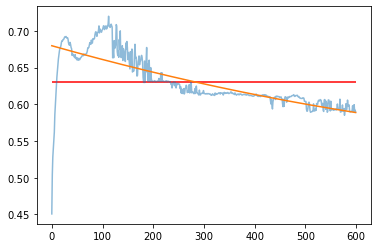

0 0 0.6982762267343485 221 5.1e-07


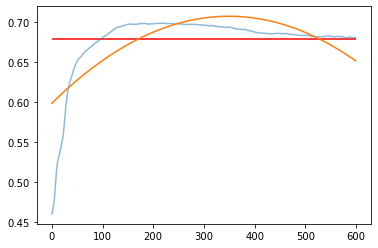

best UAC in cluster 0: 0.7209813874788495 with model 1, f1: 0.1875
best UAC in cluster 0: 0.7242174280879865 with model 1, f1: 0.1875
best UAC in cluster 0: 0.7277707275803722 with model 1, f1: 0.1875
best UAC in cluster 0: 0.7305308798646362 with model 1, f1: 0.1875
best UAC in cluster 0: 0.7325507614213198 with model 1, f1: 0.20833333333333334
best UAC in cluster 0: 0.7335871404399322 with model 1, f1: 0.20833333333333334
best UAC in cluster 0: 0.7346869712351946 with model 1, f1: 0.20833333333333334
best UAC in cluster 0: 0.7352368866328257 with model 1, f1: 0.20833333333333334
best UAC in cluster 0: 0.7362521150592216 with model 1, f1: 0.20833333333333334
best UAC in cluster 0: 0.7378807106598984 with model 1, f1: 0.20833333333333334
best UAC in cluster 0: 0.7386209813874788 with model 1, f1: 0.20833333333333334
best UAC in cluster 0: 0.7402072758037226 with model 1, f1: 0.20833333333333334
best UAC in cluster 0: 0.7403130287648055 with model 1, f1: 0.22916666666666666
best UAC in 

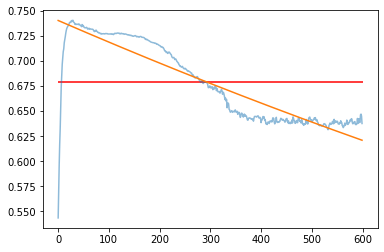

0 1 0.7182529610829104 506 5.1e-07


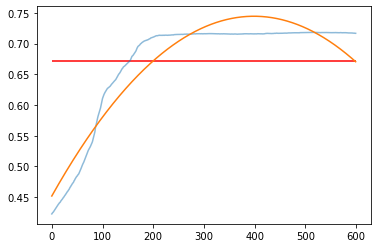

0 2 0.7199450084602369 39 5.1e-06


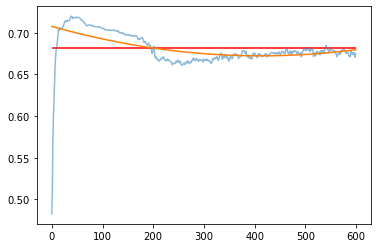

0 2 0.7092005076142132 447 5.1e-07


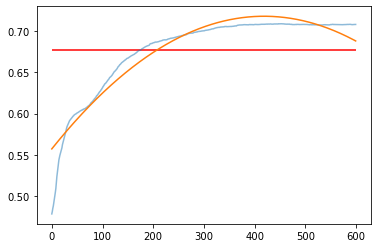

0 3 0.7205795262267344 79 5.1e-06


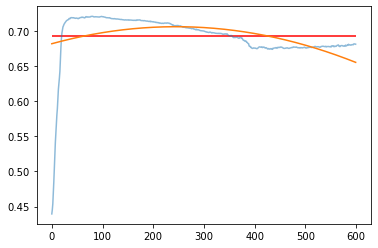

0 3 0.7076353637901862 588 5.1e-07


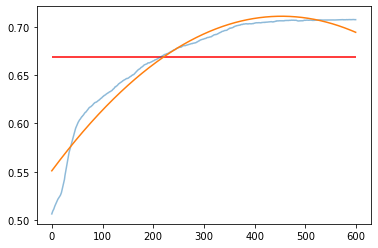

best UAC in cluster 2: 0.41969596827495037 with model 0, f1: 0.0
best UAC in cluster 2: 0.42333113020489094 with model 0, f1: 0.0
best UAC in cluster 2: 0.4360541969596828 with model 0, f1: 0.0
best UAC in cluster 2: 0.43737607402511564 with model 0, f1: 0.0
best UAC in cluster 2: 0.4477858559153999 with model 0, f1: 0.0
best UAC in cluster 2: 0.45489094514210177 with model 0, f1: 0.0
best UAC in cluster 2: 0.4562128222075347 with model 0, f1: 0.0
best UAC in cluster 2: 0.4583608724388632 with model 0, f1: 0.058823529411764705
best UAC in cluster 2: 0.46150033046926636 with model 0, f1: 0.058823529411764705
best UAC in cluster 2: 0.46513549239920693 with model 0, f1: 0.058823529411764705
best UAC in cluster 2: 0.46959682749504295 with model 0, f1: 0.058823529411764705
best UAC in cluster 2: 0.47273628552544616 with model 0, f1: 0.058823529411764705
best UAC in cluster 2: 0.47851949768671515 with model 0, f1: 0.058823529411764705
best UAC in cluster 2: 0.481163251817581 with model 0, f1

In [ ]:
n_epochs = 600
hists = train(models, X_train, Y_train, Y1_17, train_labels,
              X_val, Y_val, Y1_18,val_labels, n_epochs,5.1e-07)


In [ ]:
predictions = np.zeros(len(Y_test))
auc_clusters = {}
f1_clusters = {}
for clust in train_labels[0].unique():
  
    idxs = test_labels[test_labels[0] == clust].index
    xt = torch.tensor(X_test[idxs]).float().to(device)
    yt = Y_test[idxs]
    y1 = Y1_19[idxs]

    size = hists[2][clust][1]
    if size == 0: 
        model = RNNCNN()
        model.load_state_dict(hists[3][clust])
        model.eval()
    elif size ==1: 
        model = RNNCNN1()
        model.load_state_dict(hists[3][clust])
        model.eval()
    elif size == 2: 
        model = RNNCNN2()
        model.load_state_dict(hists[3][clust])
        model.eval()
    elif size == 3: 
        model = RNNCNN3()
        model.load_state_dict(hists[3][clust])
        model.eval()
            
    preds = model(xt, y1)
    preds = preds.cpu().squeeze().detach().numpy()  
    auc = roc_auc_score(yt, preds)
    auc_clusters[clust] = auc

    Yhat = np.zeros(len(yt))
    pos_idxs = preds.argsort()[- (yt == 1).sum() : ]
    Yhat[pos_idxs] = 1
    f1_clusters[clust] = f1 = f1_score(yt, Yhat)

    predictions[idxs] = preds

pos_idxs = predictions.argsort()[- (Y_test == 1).sum() : ]
Yhat = np.zeros(len(Y_test))
Yhat[pos_idxs] = 1
auc = roc_auc_score(Y_test, predictions)
f1 = f1_score(Y_test, Yhat)
print(auc, f1, f1_clusters, auc_clusters)

name = "Nijmegen"
with open ("../Results/" + name +".csv", "a+") as f:
    f.write("\nRNN_cluster,{},{}".format(auc,f1))

    
with open ("../Results/" + name +"AUC.csv", "a+") as f:
    f.write("\nRNNCNN_clust,{},{}".format(auc_clusters[0],auc_clusters[1],auc_clusters[1]))
    
with open ("../Results/" + name +"f1.csv", "a+") as f:
    f.write("\nRNNCNN_clust,{},{}".format(f1_clusters[0],f1_clusters[1],f1_clusters[2]))
    
with open ("../Results/modellen.csv", "a") as f:
    f.write(name + ",RNNCNNcluster," + str(hists[2]))

In [ ]:
hists[2]

X_val


In [ ]:
class RNNCNN(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 15, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 15, out_channels = 2, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 57 ,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,10,10] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 100).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [45]:
X_val.shape

torch.Size([5967, 4, 39, 11, 11])